# H1N1 Vaccines

Kendall McNeil 2023

# 1. Project Description

*Objective: Predict how likely individuals are to review their H1N1 and seasonal flu vaccines.

*Description: Beginning in spring 2009, a pandemic caused by the H1N1 influenza virus, colloquially named "swine flu," swept across the globe. It is estimated that in the first year, swine flu was responsible for 151,000-575,000 deaths worldwide. This project analyzes over 26,000 data points collected through the National 2009 H1N1 Flu Survey (NHFS), which was conducted jointly by the National Center for Health Statistics (NCHS) and Centers for Disease Control and Prevention (CDC). Analysis of this data will be used to inform marketing strategies for h1n1 vaccines.

Methodology: Logistic Regression

Target: h1n1_vaccine (1 for no vaccine and 0 for vaccine) 
*explanation later on

Performance Metrics: Performance will be evaluated according to the area under the receiver operating characteristic curve (ROC) and the accuracy, recall, precision, and f1 scores. A higher value indicates stronger performance.

# 2. Imports and Data

In [367]:
import pandas as pd
import numpy as np
from numpy import ravel
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures,\
Normalizer, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold 

In [295]:
cd data

[WinError 2] The system cannot find the file specified: 'data'
C:\Users\Jackson\Documents\flatiron\H1N1-Vaccines\data


In [296]:
trainfeatures = pd.read_csv('training_set_features.csv')

In [297]:
trainlabels = pd.read_csv('training_set_labels.csv')

In [298]:
trainfeatures.shape, trainlabels.shape

((26707, 36), (26707, 3))

Merging features and labels dataframes to create one comprehensive dataset that includes x variables and target variables.

In [299]:
df = trainfeatures.merge(trainlabels,on='respondent_id',how='outer')

In [300]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [301]:
df.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

# 3. Exploratory Data Analysis

Checking for duplicates, checking null values, and exploring dtypes

In [302]:
df.duplicated().sum()

0

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

*In our question, we want to uncover who is will not receive a h1n1 vaccine, therefore, we will switch our target variable so that 0 represents receiving the vaccine and 1 represents not receiving the vaccine.

In [304]:
df.h1n1_vaccine = df.h1n1_vaccine.replace(0, "no vaccine")
df.h1n1_vaccine = df.h1n1_vaccine.replace(1, "vaccine")

In [305]:
df.h1n1_vaccine.value_counts()

no vaccine    21033
vaccine        5674
Name: h1n1_vaccine, dtype: int64

In [306]:
df.h1n1_vaccine = df.h1n1_vaccine.replace("no vaccine", 1)
df.h1n1_vaccine = df.h1n1_vaccine.replace("vaccine", 0)

In [307]:
df.h1n1_vaccine.value_counts()

1    21033
0     5674
Name: h1n1_vaccine, dtype: int64

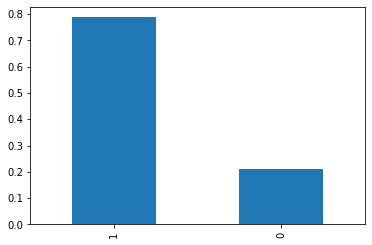

In [308]:
df['h1n1_vaccine'].value_counts(normalize=True).plot(kind='bar');

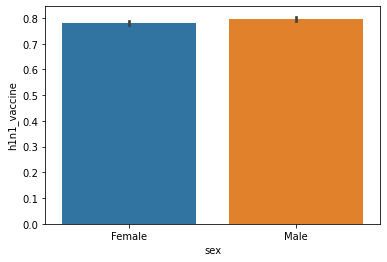

In [220]:
sns.barplot(x=df['sex'], y=df['h1n1_vaccine']);

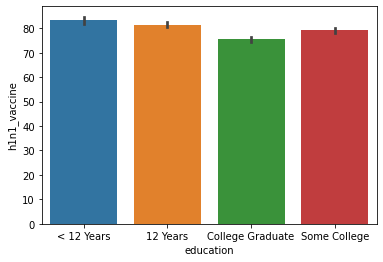

In [221]:
sns.barplot(x=df['education'], y=df['h1n1_vaccine'] * 100);

# 4. Pipeline Creation - H1N1 Vaccine and All Variables

Creating categorical and binary columns to use in pipeline, excluding respondent ID and both target variables.

In [222]:
df.sex.value_counts()

Female    15858
Male      10849
Name: sex, dtype: int64

In [223]:
df.marital_status.value_counts()

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

In [224]:
df.rent_or_own.value_counts()

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

In [225]:
categorical_columns = ['age_group','education','race','income_poverty','employment_status', 'hhs_geo_region','census_msa',
                       'household_adults','household_children','employment_industry','employment_occupation']

#binary columns include columns that are binary but need to be one-hot-encoded because they are objects
binary_columns = ['sex','marital_status','rent_or_own']

#simple impute only includes: (1) binary variables that contain 0 and 1 already and (2) survey data that is on a scale from 0-x. 
simple_impute_only = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','h1n1_knowledge',
                       'h1n1_concern', 'behavioral_antiviral_meds','behavioral_avoidance', 'behavioral_face_mask',
                      'behavioral_wash_hands','behavioral_large_gatherings','behavioral_outside_home',
                      'behavioral_touch_face','doctor_recc_h1n1','doctor_recc_seasonal','chronic_med_condition',
                      'child_under_6_months','health_worker','health_insurance']

In [226]:
X = df.iloc[:,1:-2]
y = df['h1n1_vaccine']

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [228]:
X_train.shape, X_test.shape

((20030, 35), (6677, 35))

In [229]:
subpipe_categorical = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_binary = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_simple_impute_only = Pipeline([
    ('sio_impute', SimpleImputer(strategy='most_frequent'))
])

In [230]:
CT = ColumnTransformer(transformers=[
    ('categorical', subpipe_categorical, categorical_columns),
    ('binary', subpipe_binary, binary_columns),
    ('simple_impute_only', subpipe_simple_impute_only, simple_impute_only)
], remainder='passthrough')

# 4A. Dummy Model

In [231]:
dummy_pipeline = Pipeline(steps=[
    ('CT',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

In [232]:
dummy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [233]:
print('Training set score: ' + str(dummy_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(dummy_pipeline.score(X_test,y_test)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


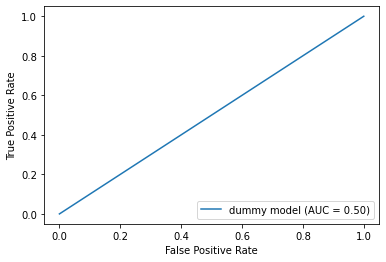

In [234]:
plot_roc_curve(dummy_pipeline, X_test, y_test, name='dummy model');

In [ ]:
print(f"""
Our dummy model's accuracy on the test set is {round(accuracy_score(y_test, y_preds), 4) * 100}%. \n
Our dummy model's recall on the test set is {round(recall_score(y_test, y_preds), 5) * 100}%. \n
Our dummy model's precision on the test set is {round(precision_score(y_test, y_preds), 4) * 100}%. \n
Our dummy model's f1-score on the test is {round(f1_score(y_test, y_preds), 3) * 100}%.
""")

# 4B. First Simple Model

In [235]:
fsm_pipeline = Pipeline([
    ('CT',CT),
    ('first_simple_model', LogisticRegression())
])

In [236]:
fsm_pipeline.fit(X_train, y_train)

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [237]:
print('Training set score: ' + str(fsm_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(fsm_pipeline.score(X_test,y_test)))

Training set score: 0.8379930104842735
Test set score: 0.8397483899955069


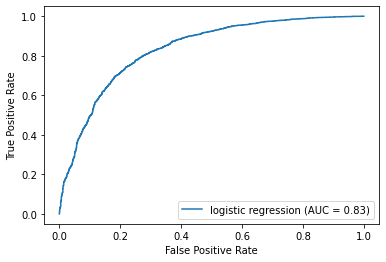

In [238]:
plot_roc_curve(fsm_pipeline, X_test, y_test, name='logistic regression');

# 4C. Tuning First Simple Model with GridSearching

In [239]:
params = {
    'first_simple_model__solver' : ['liblinear','lbfgs'],
    'first_simple_model__max_iter': [10, 100,1000,10_000],
    'first_simple_model__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'first_simple_model__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [240]:
gridsearch = GridSearchCV(
    estimator = fsm_pipeline,
    param_grid=params,
    cv=5,
    verbose=1
)

Performed gridsearch. Commented out because the code took about 30 minutes to run.

In [241]:
gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                        

In [242]:
best_params = gridsearch.best_params_
best_params

{'first_simple_model__C': 1,
 'first_simple_model__max_iter': 1000,
 'first_simple_model__solver': 'lbfgs',
 'first_simple_model__tol': 0.0001}

In [243]:
best_pipe = gridsearch.best_estimator_
best_pipe

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [244]:
result_df = pd.DataFrame.from_dict(gridsearch.cv_results_, orient='columns')
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_first_simple_model__C,param_first_simple_model__max_iter,param_first_simple_model__solver,param_first_simple_model__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.811465,0.027815,0.037581,0.002621,0.0001,10,liblinear,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
1,0.773204,0.023253,0.037108,0.002289,0.0001,10,liblinear,0.001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
2,0.782362,0.030216,0.038123,0.003173,0.0001,10,liblinear,0.01,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
3,0.814082,0.033921,0.039549,0.006591,0.0001,10,liblinear,0.1,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
4,0.794235,0.016641,0.058107,0.000802,0.0001,10,lbfgs,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.949539,0.200113,0.046060,0.008402,1,10000,liblinear,0.1,"{'first_simple_model__C': 1, 'first_simple_mod...",0.829006,0.830504,0.830255,0.835996,0.834249,0.832002,0.002656,61
156,4.470533,0.457407,0.073779,0.008474,1,10000,lbfgs,0.0001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831253,0.836995,0.839990,0.835497,0.836495,0.836046,0.002826,1
157,4.484594,0.461865,0.075593,0.016750,1,10000,lbfgs,0.001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831253,0.836995,0.839990,0.835497,0.836495,0.836046,0.002826,1
158,4.053953,0.160245,0.079724,0.008441,1,10000,lbfgs,0.01,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831253,0.836995,0.839990,0.835497,0.836495,0.836046,0.002826,1


In [245]:
print('Training set score: ' + str(best_pipe.score(X_train,y_train)))
print('Test set score: ' + str(best_pipe.score(X_test,y_test)))

Training set score: 0.8380928607089366
Test set score: 0.8398981578553243


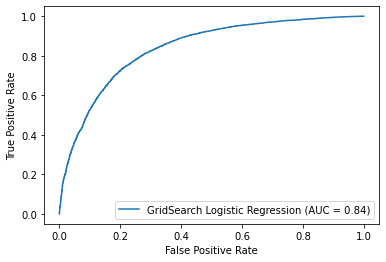

In [246]:
plot_roc_curve(best_pipe, X_train, y_train, name='GridSearch Logistic Regression');

In [311]:
cv = cross_validate(best_pipe, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

{'fit_time': array([4.12116909, 3.880301  , 4.24536943, 3.69485092, 4.04206395]),
 'score_time': array([0.08161712, 0.05872226, 0.04671907, 0.08682752, 0.04711246]),
 'test_r2': array([-0.00862265,  0.02569439,  0.04359894,  0.01758479,  0.02354786]),
 'train_r2': array([0.03878911, 0.03468774, 0.02611216, 0.02627628, 0.02925973]),
 'test_neg_mean_squared_error': array([-0.16874688, -0.16300549, -0.16000999, -0.16450325, -0.16350474]),
 'train_neg_mean_squared_error': array([-0.16088367, -0.16157014, -0.16300549, -0.16294309, -0.16244383])}

In [312]:
y_preds4c = best_pipe.predict(X_test)

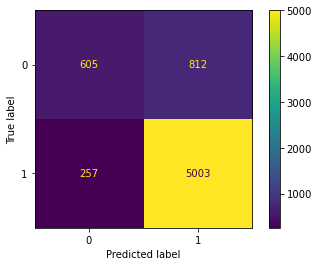

In [314]:
plot_confusion_matrix(best_pipe, X_test, y_test);

In [315]:
print(f"""
Our 4C model's accuracy on the test set is {round(accuracy_score(y_test, y_preds4c), 4) * 100}%. \n
Our 4C model's recall on the test set is {round(recall_score(y_test, y_preds4c), 5) * 100}%. \n
Our 4C model's precision on the test set is {round(precision_score(y_test, y_preds4c), 4) * 100}%. \n
Our 4C model's f1-score on the test is {round(f1_score(y_test, y_preds4c), 3) * 100}%.
""")


Our 4C model's accuracy on the test set is 83.99%. 

Our 4C model's recall on the test set is 95.114%. 

Our 4C model's precision on the test set is 86.04%. 

Our 4C model's f1-score on the test is 90.3%.



# 4D. Logistic Regression with SMOTE

In [247]:
smote_pipeline = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('best_pipe', LogisticRegression(C=1,max_iter=100, solver='lbfgs',tol=.0001))
])

In [248]:
smote_pipeline.fit(X_train, y_train)

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [249]:
print('Training set score: ' + str(smote_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(smote_pipeline.score(X_test,y_test)))

Training set score: 0.7839740389415876
Test set score: 0.7831361389845739


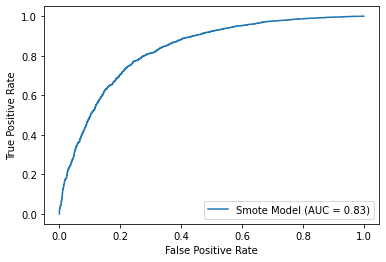

In [250]:
plot_roc_curve(smote_pipeline, X_test, y_test, name='Smote Model');

In [316]:
cv = cross_validate(smote_pipeline, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

{'fit_time': array([4.18873596, 4.30986524, 4.04695535, 4.14276338, 4.16654062]),
 'score_time': array([0.06755877, 0.06117439, 0.06802416, 0.05641723, 0.04286766]),
 'test_r2': array([-0.3786499 , -0.29807945, -0.35179308, -0.2418086 , -0.2999485 ]),
 'train_r2': array([-0.26172911, -0.28894726, -0.27552461, -0.30861607, -0.28586725]),
 'test_neg_mean_squared_error': array([-0.23065402, -0.21717424, -0.22616076, -0.20793809, -0.21767349]),
 'train_neg_mean_squared_error': array([-0.21118323, -0.21573889, -0.21349226, -0.21898402, -0.21517723])}

In [317]:
y_preds4d = smote_pipeline.predict(X_test)

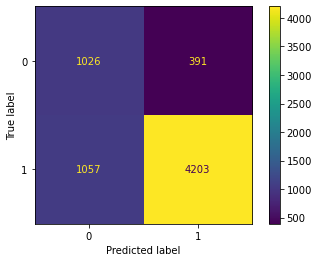

In [318]:
plot_confusion_matrix(smote_pipeline, X_test, y_test);

In [319]:
print(f"""
Our 4d model's accuracy on the test set is {round(accuracy_score(y_test, y_preds4d), 4) * 100}%. \n
Our 4d model's recall on the test set is {round(recall_score(y_test, y_preds4d), 5) * 100}%. \n
Our 4d model's precision on the test set is {round(precision_score(y_test, y_preds4d), 4) * 100}%. \n
Our 4d model's f1-score on the test is {round(f1_score(y_test, y_preds4d), 3) * 100}%.
""")


Our 4d model's accuracy on the test set is 78.31%. 

Our 4d model's recall on the test set is 79.905%. 

Our 4d model's precision on the test set is 91.49000000000001%. 

Our 4d model's f1-score on the test is 85.3%.



The SMOTE model performs worse overall, therefore we will move on with the "best_pipe" from 4C.

# 5. Pipeline Creation - H1N1 Vaccine and Select Variables

Let's try to limit the columns and see how the model performs.

In [265]:
X_select = df[['age_group', 'education', 'race', 'income_poverty', 'employment_status', 'marital_status', 'sex','hhs_geo_region']]
y_select = df['h1n1_vaccine']

In [266]:
categorical_columns = ['age_group', 'education', 'race', 'income_poverty', 'employment_status', 'hhs_geo_region']
binary_columns = ['sex', 'marital_status']

In [267]:
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_select, y_select, random_state=42)

In [268]:
subpipe_categorical = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_binary = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [269]:
CT = ColumnTransformer(transformers=[
    ('categorical', subpipe_categorical, categorical_columns),
    ('binary', subpipe_binary, binary_columns)
], remainder='passthrough')

# 5A. Dummy Model

In [270]:
dummy_pipeline = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [271]:
dummy_pipeline.fit(X_train_select,y_train_select)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [272]:
print('Training set score: ' + str(dummy_pipeline.score(X_train_select,y_train_select)))
print('Test set score: ' + str(dummy_pipeline.score(X_test_select,y_test_select)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


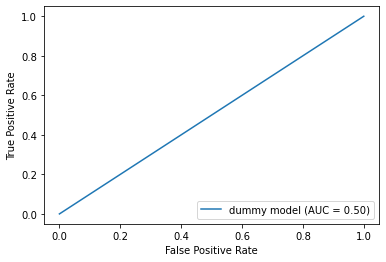

In [273]:
plot_roc_curve(dummy_pipeline, X_test_select, y_test_select, name='dummy model');

# 5B. First Simple Model (Select Variables)

In [275]:
fsm_pipeline = Pipeline([
    ('CT', CT),
    ('first_simple_model', LogisticRegression())
])

In [276]:
fsm_pipeline.fit(X_train_select,y_train_select)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [277]:
print('Training set score: ' + str(fsm_pipeline.score(X_train_select,y_train_select)))
print('Test set score: ' + str(fsm_pipeline.score(X_test_select,y_test_select)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


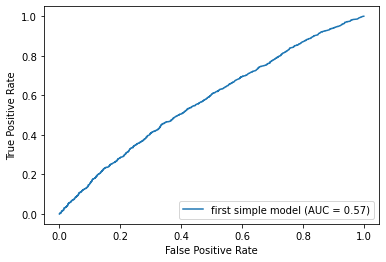

In [278]:
plot_roc_curve(fsm_pipeline, X_test_select, y_test_select, name='first simple model');

# 5C. Tuning First Simple Model with GridSearching

In [279]:
params = {
    'first_simple_model__solver' : ['liblinear','lbfgs'],
    'first_simple_model__max_iter': [10, 100,1000,10_000],
    'first_simple_model__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'first_simple_model__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [280]:
gridsearch_select = GridSearchCV(
    estimator = fsm_pipeline,
    param_grid = params,
    cv=5,
    verbose=1)

In [281]:
gridsearch_select.fit(X_train_select,y_train_select)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                        

In [282]:
best_params_select = gridsearch_select.best_params_
best_params_select

{'first_simple_model__C': 0.0001,
 'first_simple_model__max_iter': 10,
 'first_simple_model__solver': 'liblinear',
 'first_simple_model__tol': 0.0001}

In [283]:
best_pipe_select = gridsearch_select.best_estimator_
best_pipe_select

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [284]:
result_df = pd.DataFrame.from_dict(gridsearch_select.cv_results_,orient='columns')
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_first_simple_model__C,param_first_simple_model__max_iter,param_first_simple_model__solver,param_first_simple_model__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.511022,0.032136,0.019669,0.002609,0.0001,10,liblinear,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
1,0.520182,0.043442,0.020029,0.003144,0.0001,10,liblinear,0.001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
2,0.487306,0.016347,0.018167,0.000749,0.0001,10,liblinear,0.01,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
3,0.504832,0.019206,0.017817,0.001299,0.0001,10,liblinear,0.1,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
4,0.519785,0.018308,0.021339,0.000630,0.0001,10,lbfgs,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.490316,0.006463,0.017240,0.000321,1,10000,liblinear,0.1,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
156,0.687828,0.029789,0.029676,0.002255,1,10000,lbfgs,0.0001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
157,0.652081,0.035566,0.024760,0.004182,1,10000,lbfgs,0.001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
158,0.663083,0.031995,0.026485,0.002795,1,10000,lbfgs,0.01,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1


In [285]:
print('Training set score: ' + str(best_pipe_select.score(X_train_select,y_train)))
print('Test set score: ' + str(best_pipe_select.score(X_test_select,y_test)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


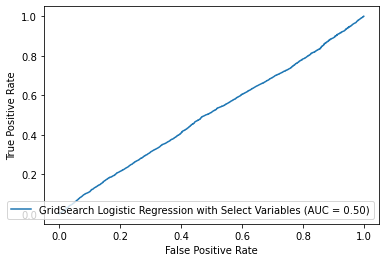

In [286]:
plot_roc_curve(best_pipe_select, X_train_select, y_train_select, name = 'GridSearch Logistic Regression with Select Variables');

Overall, this is not a good performance. Let's go back to using all columns in our model.

# 6. Selecting Final Model & Exploring Predictions

Refer to section 4C of selecting the best model including all the variables.

In [329]:
final_model = best_pipe
final_model

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

# 6A. Final Model Evaluation

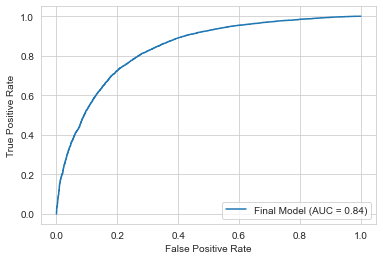

In [369]:
plot_roc_curve(best_pipe, X_train, y_train, name='Final Model');

In [330]:
print('Training set score: ' + str(final_model.score(X_train,y_train)))
print('Test set score: ' + str(final_model.score(X_test,y_test)))

Training set score: 0.8380928607089366
Test set score: 0.8398981578553243


In [321]:
cv = cross_validate(final_model, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

{'fit_time': array([4.17174792, 4.02284241, 3.94970942, 3.40463901, 4.42985582]),
 'score_time': array([0.0636034 , 0.06664085, 0.06404734, 0.07301259, 0.09145474]),
 'test_r2': array([-0.00862265,  0.02569439,  0.04359894,  0.01758479,  0.02354786]),
 'train_r2': array([0.03878911, 0.03468774, 0.02611216, 0.02627628, 0.02925973]),
 'test_neg_mean_squared_error': array([-0.16874688, -0.16300549, -0.16000999, -0.16450325, -0.16350474]),
 'train_neg_mean_squared_error': array([-0.16088367, -0.16157014, -0.16300549, -0.16294309, -0.16244383])}

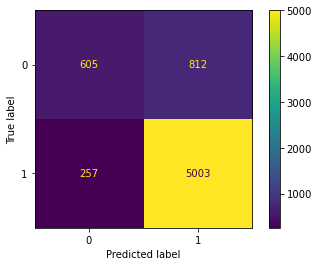

In [331]:
plot_confusion_matrix(final_model, X_test, y_test);

In [332]:
final_preds = final_model.predict(X_test)

In [374]:
print(f"""
The final model's accuracy on the test set is {round(accuracy_score(y_test, final_preds), 4) * 100}%. \n
The final model's recall on the test set is {round(recall_score(y_test, final_preds), 4) * 100}%. \n
The final model's precision on the test set is {round(precision_score(y_test, final_preds), 4) * 100}%. \n
The final model's f1-score on the test is {round(f1_score(y_test, final_preds), 4) * 100}%. \n
The final model's ROC AUC score on the test is {round(roc_auc_score(y_test, final_preds, average='macro'), 5) * 100}%. 
""")


The final model's accuracy on the test set is 83.99%. 

The final model's recall on the test set is 95.11%. 

The final model's precision on the test set is 86.04%. 

The final model's f1-score on the test is 90.35%. 

The final model's ROC AUC score on the test is 68.905%. 



# 6B. Exploring Predictions to Inform Recommendations

In [341]:
X_preds = X_test.copy()

In [342]:
X_preds['Predictions'] = final_preds
X_preds['True Values'] = y_test

In [343]:
X_preds

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,Predictions,True Values
15772,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,atmpeygn,"MSA, Principle City",NaN,NaN,NaN,NaN,1,1
9407,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,fpwskwrf,"MSA, Principle City",1.0,1.0,NaN,NaN,1,1
16515,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Own,Employed,atmpeygn,"MSA, Not Principle City",0.0,1.0,mfikgejo,mxkfnird,1,1
23353,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Own,Employed,bhuqouqj,Non-MSA,1.0,2.0,cfqqtusy,xtkaffoo,1,1
10008,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,wxleyezf,xtkaffoo,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25990,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,oxchjgsf,Non-MSA,1.0,0.0,ldnlellj,hodpvpew,1,1
14302,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,mcubkhph,ukymxvdu,1,1
3817,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Own,Employed,bhuqouqj,"MSA, Principle City",1.0,0.0,wlfvacwt,xtkaffoo,1,0
13912,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,bhuqouqj,"MSA, Not Principle City",1.0,1.0,mfikgejo,mxkfnird,1,1


In [394]:
X_preds.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'Predictions', 'True Values'],
      dtype='object')

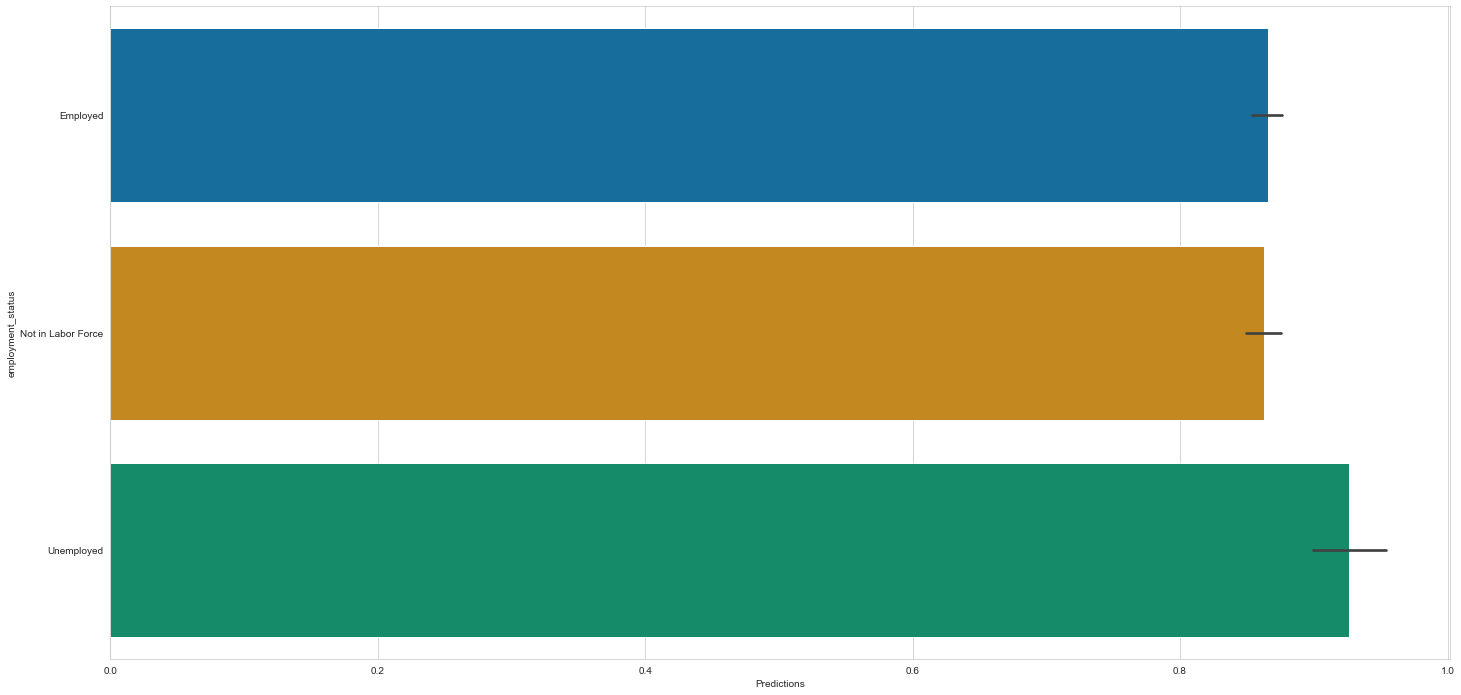

In [370]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='employment_status', palette='colorblind', data=X_preds);

In [404]:
employment_groupby = X_preds.groupby(['employment_status']).mean().sort_values(by='Predictions', ascending=False)
employment_groupby[['Predictions']]

,Predictions
employment_status,
Unemployed,0.926630
Employed,0.865459
Not in Labor Force,0.862891


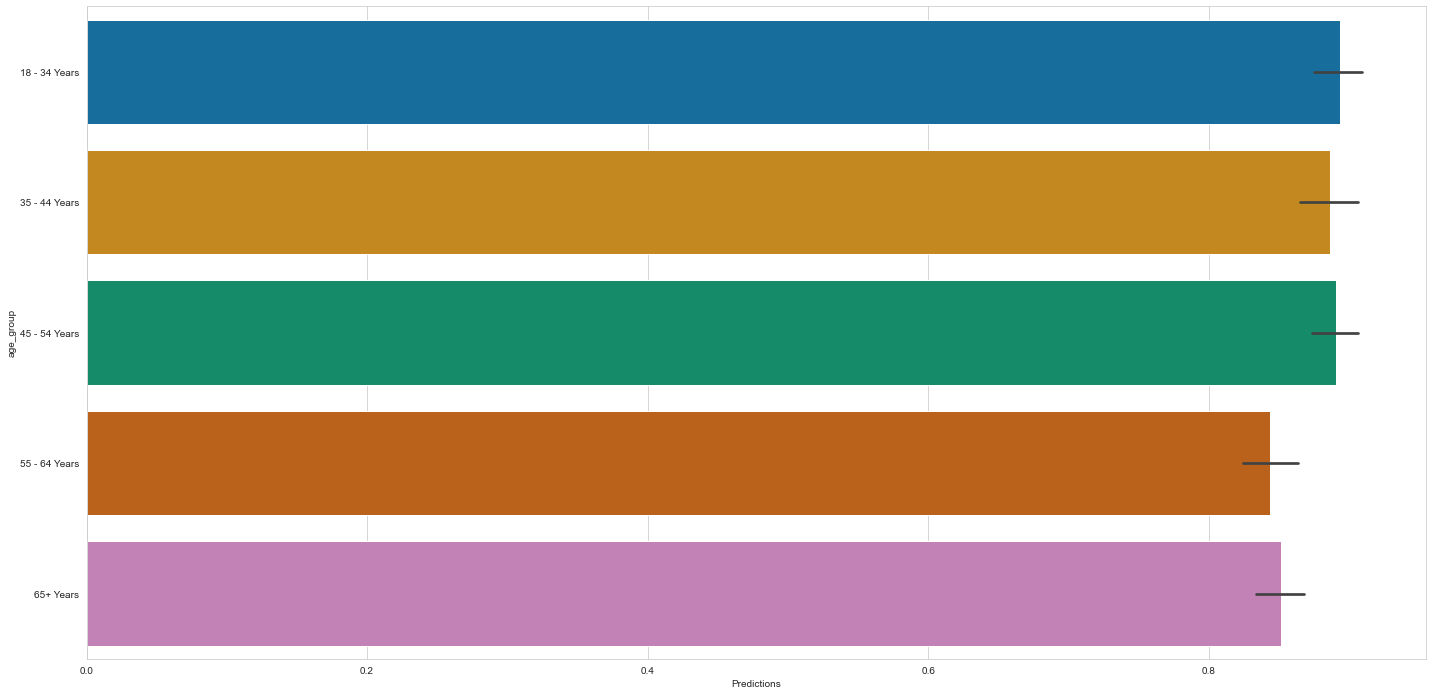

In [371]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='age_group', palette='colorblind', data=X_preds);

In [405]:
age_groupby = X_preds.groupby(['age_group']).mean().sort_values(by='Predictions', ascending=False)
age_groupby[['Predictions']]

,Predictions
age_group,
18 - 34 Years,0.893449
45 - 54 Years,0.890869
35 - 44 Years,0.886179
65+ Years,0.851225
55 - 64 Years,0.843956


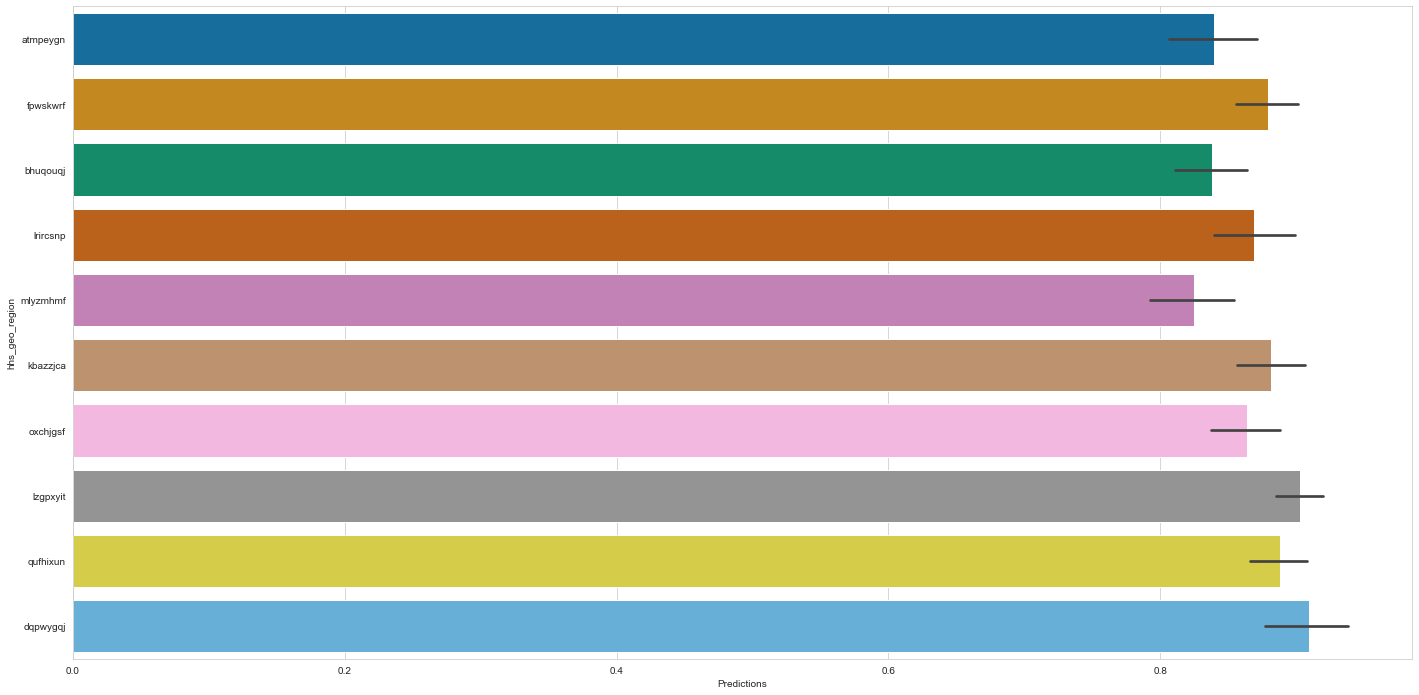

In [375]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='hhs_geo_region', palette='colorblind', data=X_preds);
#unfortunately, we do not know the regions

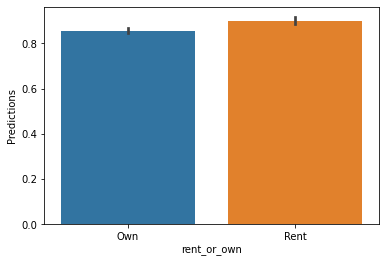

In [349]:
sns.barplot(y='Predictions', x='rent_or_own',data=X_preds);

In [406]:
rentown_groupby = X_preds.groupby(['rent_or_own']).mean().sort_values(by='Predictions', ascending=False)
rentown_groupby[['Predictions']]

,Predictions
rent_or_own,
Rent,0.900332
Own,0.856097


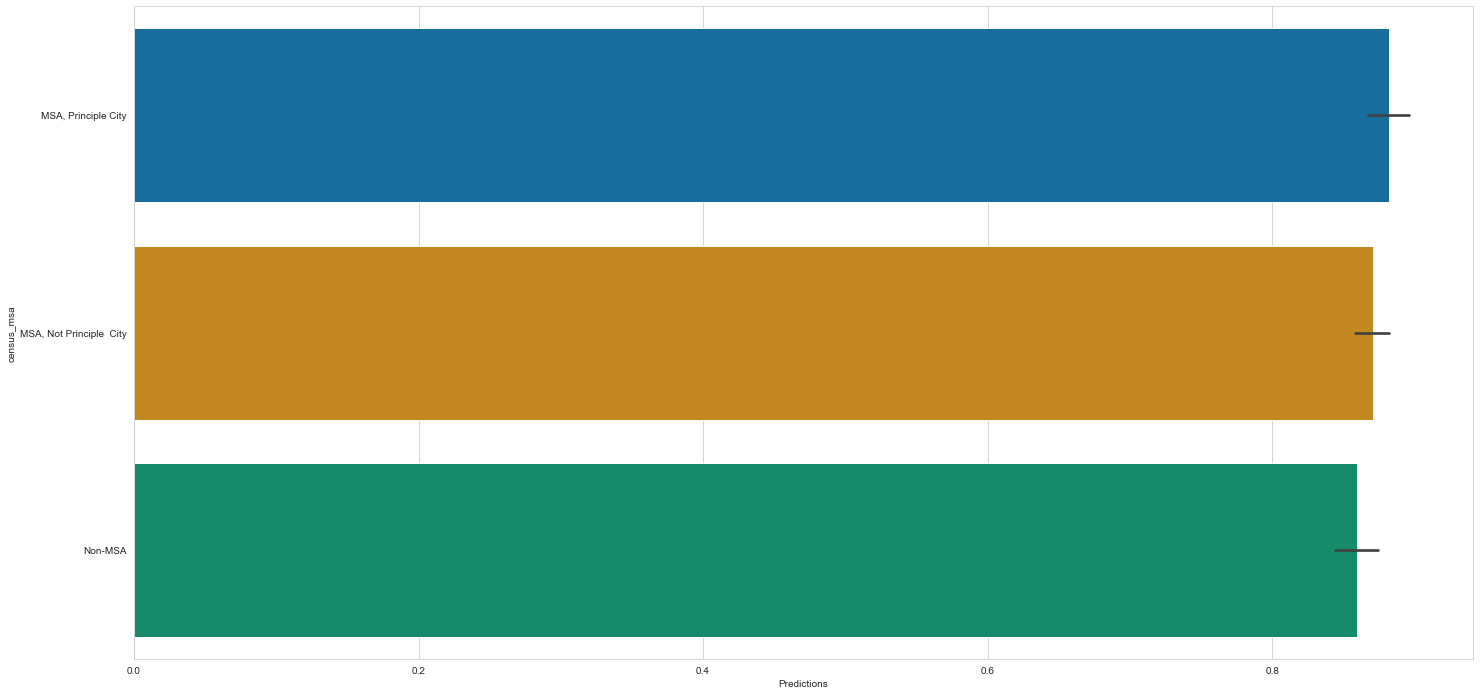

In [373]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='census_msa', palette='colorblind', data=X_preds);

In [403]:
census_msa_groupby = X_preds.groupby(['census_msa']).mean().sort_values(by='Predictions', ascending=False)
census_msa_groupby[['Predictions']]

,Predictions
census_msa,
"MSA, Principle City",0.881758
"MSA, Not Principle City",0.870540
Non-MSA,0.859259


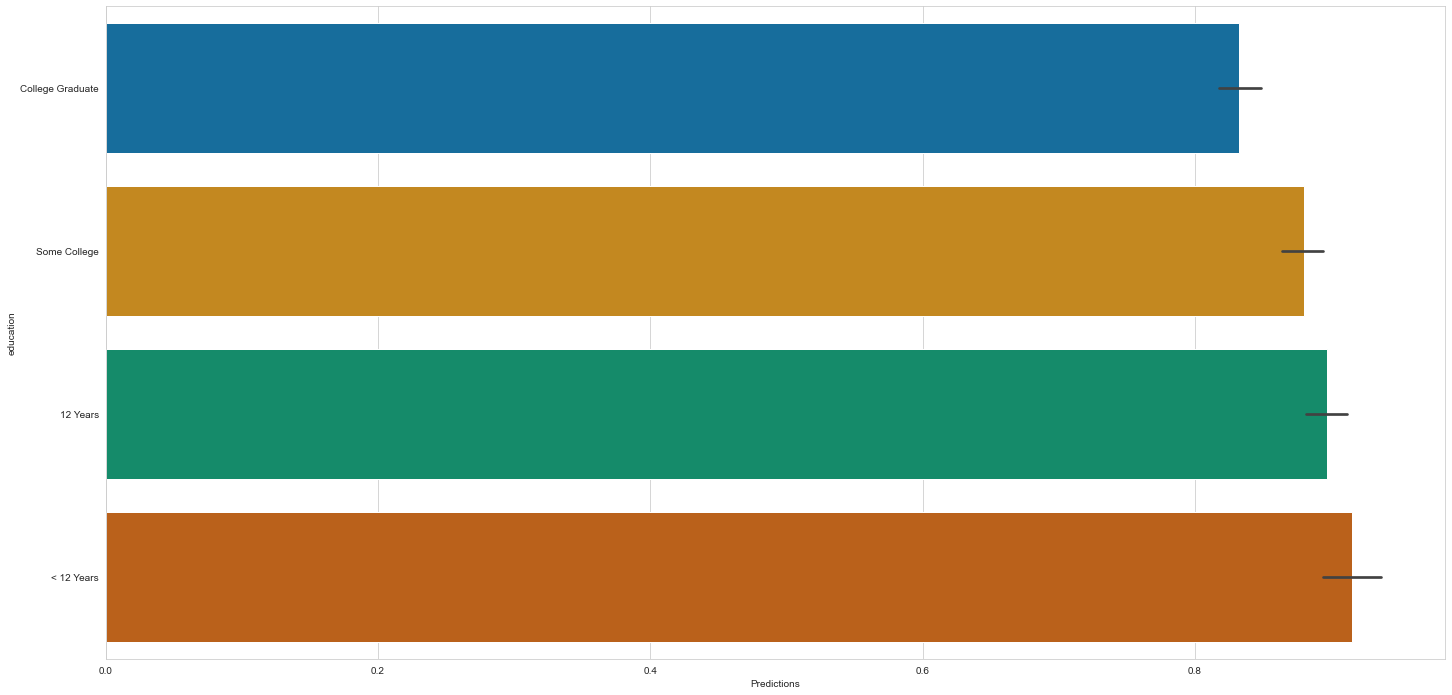

In [402]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='education', palette='colorblind', data=X_preds);

In [401]:
education_groupby = X_preds.groupby(['education']).mean().sort_values(by='Predictions', ascending=False)
education_groupby[['Predictions']]

,Predictions
education,
< 12 Years,0.915423
12 Years,0.897170
Some College,0.880000
College Graduate,0.832610


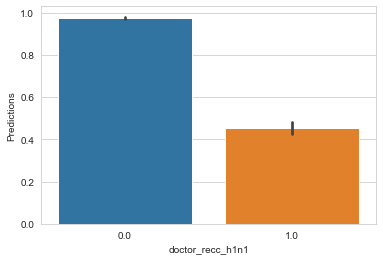

In [408]:
sns.barplot(y='Predictions', x='doctor_recc_h1n1',data=X_preds);

In [409]:
docrecommendation_groupby = X_preds.groupby(['doctor_recc_h1n1']).mean().sort_values(by='Predictions', ascending=False)
docrecommendation_groupby[['Predictions']]

,Predictions
doctor_recc_h1n1,
0.0,0.976353
1.0,0.452292


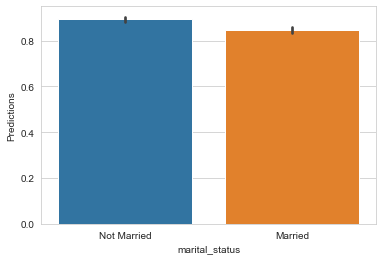

In [411]:
sns.barplot(y='Predictions', x='marital_status',data=X_preds);

In [412]:
maritalstatus_groupby = X_preds.groupby(['marital_status']).mean().sort_values(by='Predictions', ascending=False)
maritalstatus_groupby[['Predictions']]

,Predictions
marital_status,
Not Married,0.893410
Married,0.845785


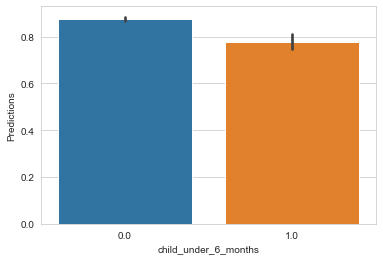

In [424]:
sns.barplot(y='Predictions', x='child_under_6_months',data=X_preds);

In [425]:
child6months_groupby = X_preds.groupby(['child_under_6_months']).mean().sort_values(by='Predictions', ascending=False)
child6months_groupby[['Predictions']]

,Predictions
child_under_6_months,
0.0,0.876754
1.0,0.778793


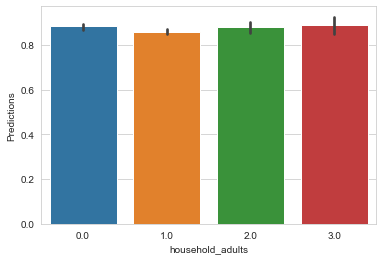

In [428]:
sns.barplot(y='Predictions', x='household_adults',data=X_preds);

In [429]:
adults_groupby = X_preds.groupby(['household_adults']).mean().sort_values(by='Predictions', ascending=False)
adults_groupby[['Predictions']]

,Predictions
household_adults,
3.0,0.888112
0.0,0.882812
2.0,0.881471
1.0,0.858794


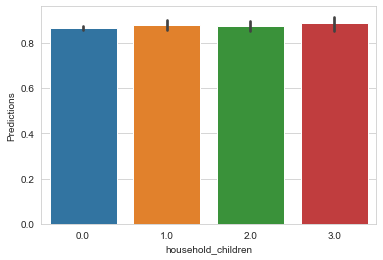

In [430]:
sns.barplot(y='Predictions', x='household_children',data=X_preds);

In [431]:
children_groupby = X_preds.groupby(['household_children']).mean().sort_values(by='Predictions', ascending=False)
children_groupby[['Predictions']]

,Predictions
household_children,
3.0,0.886792
1.0,0.878517
2.0,0.876033
0.0,0.866140


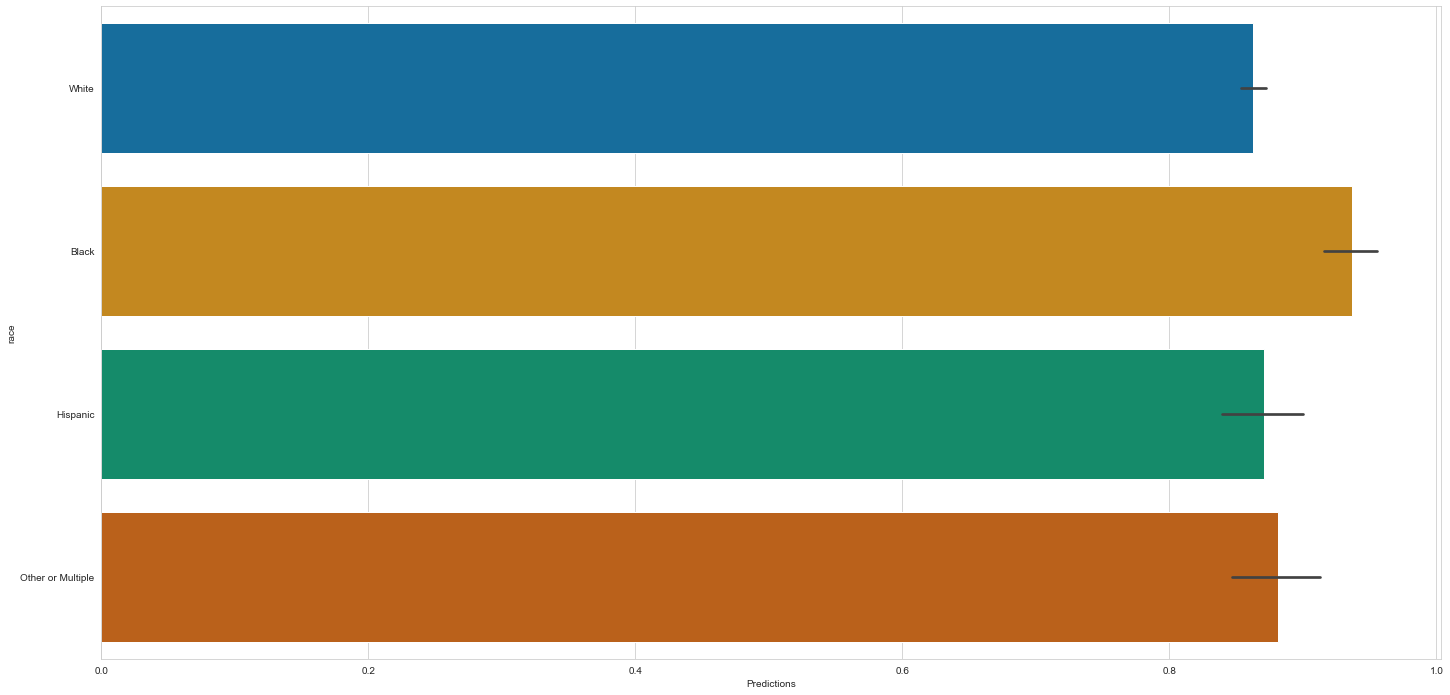

In [418]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='race', palette='colorblind', data=X_preds);

In [419]:
race_groupby = X_preds.groupby(['race']).mean().sort_values(by='Predictions', ascending=False)
race_groupby[['Predictions']]

,Predictions
race,
Black,0.936426
Other or Multiple,0.881266
Hispanic,0.870824
White,0.862920


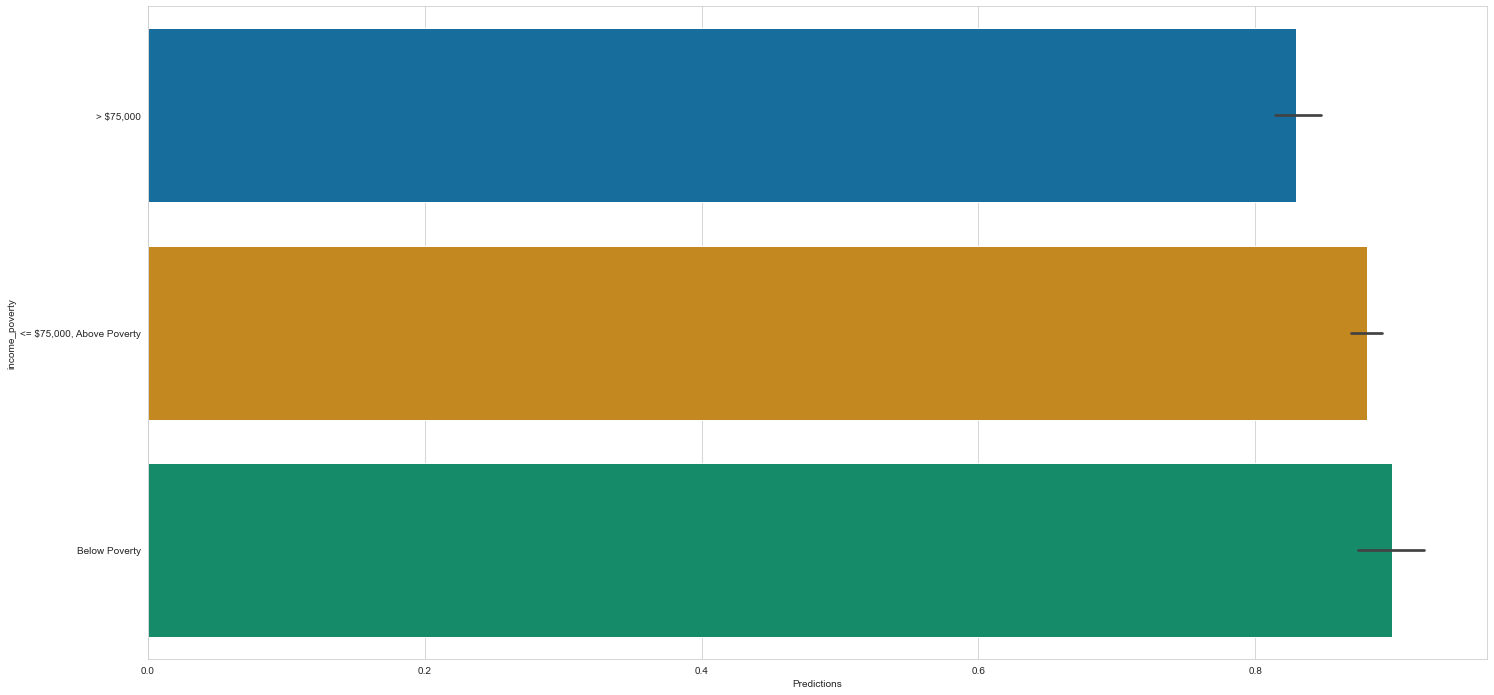

In [420]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='income_poverty', palette='colorblind', data=X_preds);

In [421]:
income_groupby = X_preds.groupby(['income_poverty']).mean().sort_values(by='Predictions', ascending=False)
income_groupby[['Predictions']]

,Predictions
income_poverty,
Below Poverty,0.898860
"<= $75,000, Above Poverty",0.880876
"> $75,000",0.829738


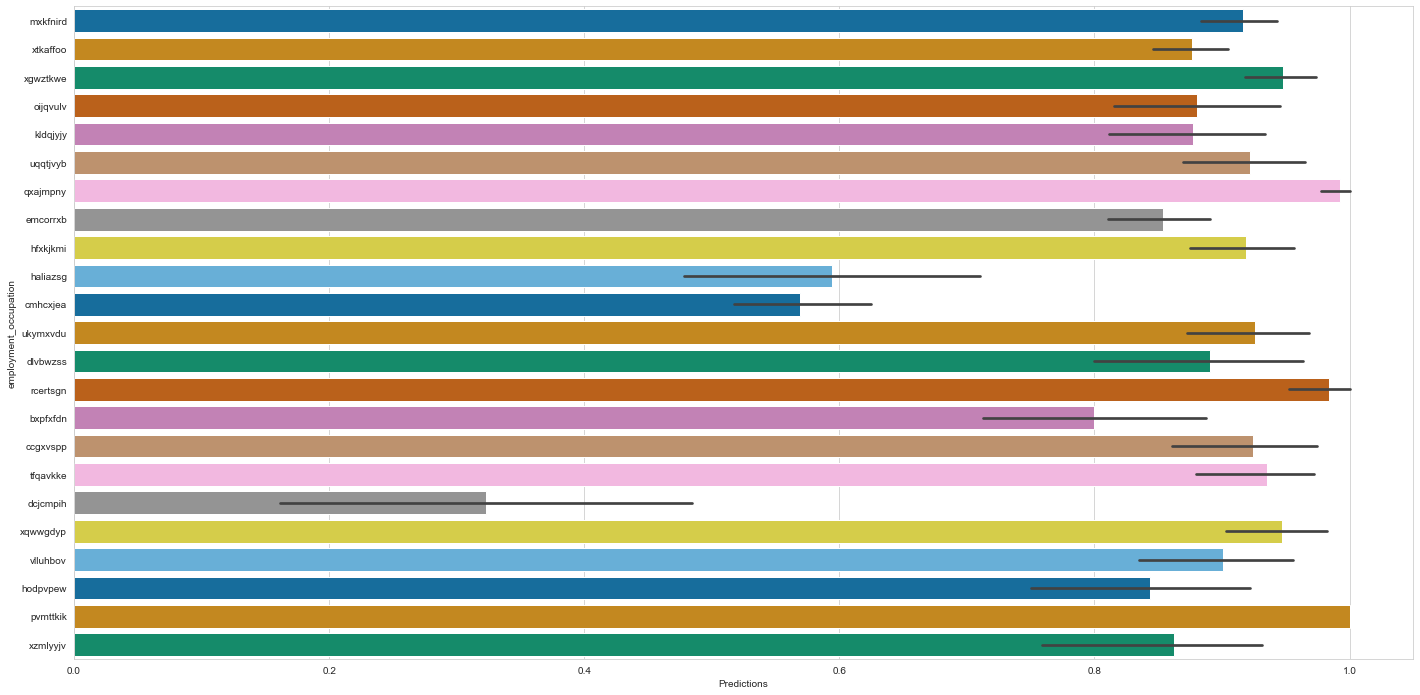

In [423]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='employment_occupation', palette='colorblind', data=X_preds);

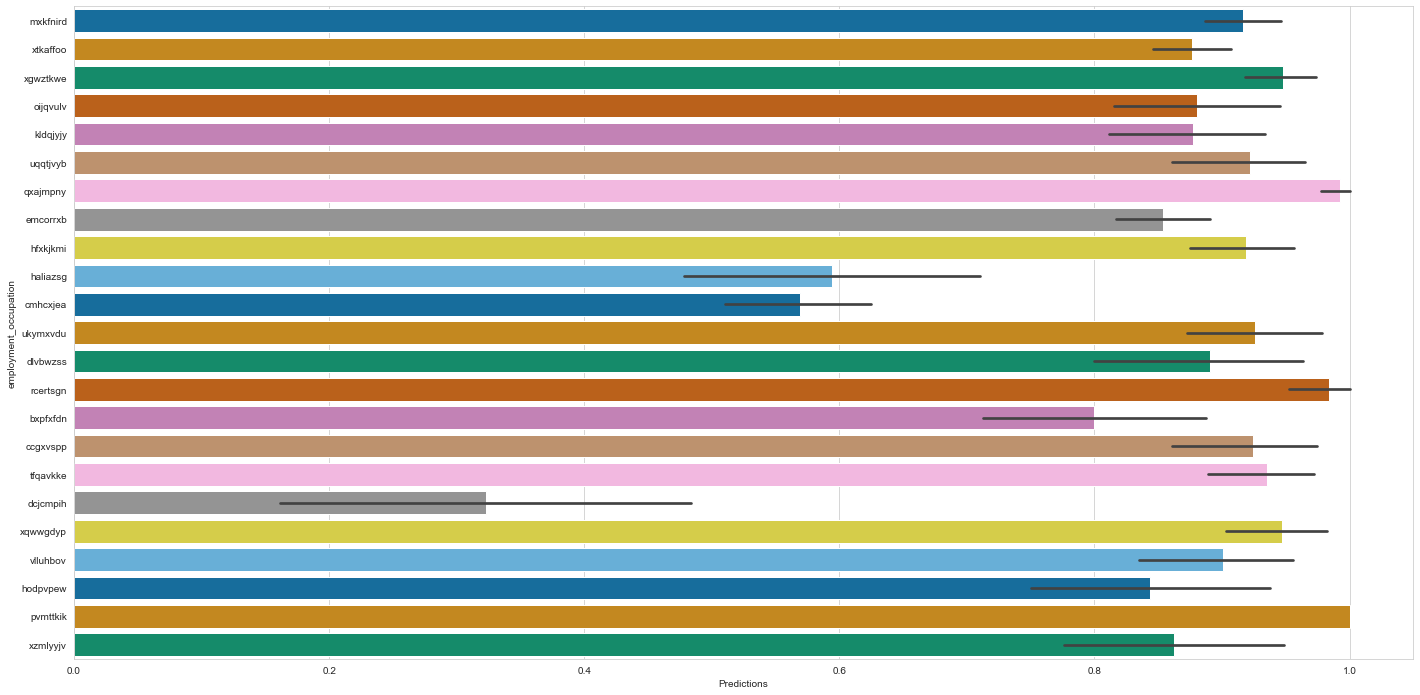

In [433]:
fig, ax = plt.subplots(figsize=(24,12))

sns.barplot(x='Predictions', y='employment_occupation', palette='colorblind', data=X_preds);

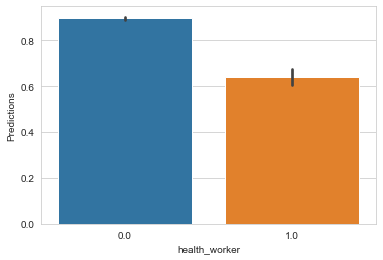

In [435]:
sns.barplot(y='Predictions', x='health_worker',data=X_preds);

In [437]:
healthworker_groupby = X_preds.groupby(['health_worker']).mean().sort_values(by='Predictions', ascending=False)
healthworker_groupby[['Predictions']]

,Predictions
health_worker,
0.0,0.895729
1.0,0.640466


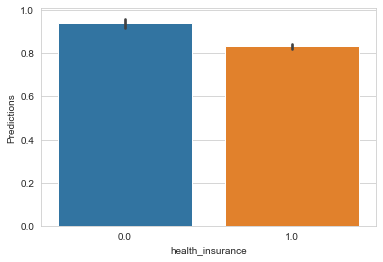

In [436]:
sns.barplot(y='Predictions', x='health_insurance',data=X_preds);

In [438]:
healthinsurance_groupby = X_preds.groupby(['health_insurance']).mean().sort_values(by='Predictions', ascending=False)
healthinsurance_groupby[['Predictions']]

,Predictions
health_insurance,
0.0,0.938190
1.0,0.832234


In [439]:
X_preds.to_csv('h1n1vaccines.csv')